In [6]:
#IMPORTS
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
import json

import utils.labeling_algorithm as labeling_algorithm
import utils.la2 as la2
from utils.features_util import compute_features, get_available_features
from utils.cross_validation import custom_ten_fold_cv_selection, remove_monoton_instances, simple_ten_fold_cv_selection
import utils.sample_weights as sample_weights
import utils.xgb_utils as xgb_utils

In [7]:
#PARAMETERS
symbols = ['AMD', 'CLX']
train_start_date = '2019-11-30'
train_end_date = '2021-11-15'
#number of previous days to observe
N = 30

In [9]:
close_prices = yf.download(symbols, train_start_date, train_end_date, progress=False)['Close']
market_series = yf.download('SPY', train_start_date, train_end_date, progress=False)['Close']

print(close_prices.shape)
print(close_prices.head())

(494, 2)
                  AMD         CLX
Date                             
2019-11-29  39.150002  148.229996
2019-12-02  38.730000  148.929993
2019-12-03  38.900002  147.949997
2019-12-04  39.689999  150.300003
2019-12-05  39.619999  150.789993


## 3-state labeling

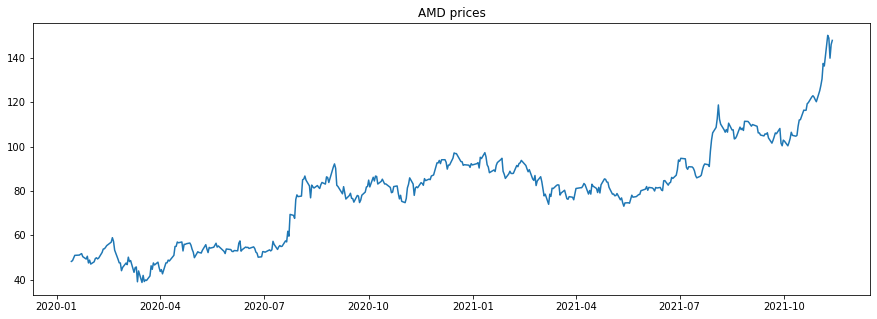

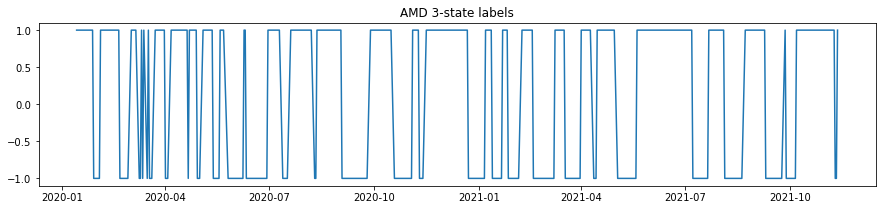

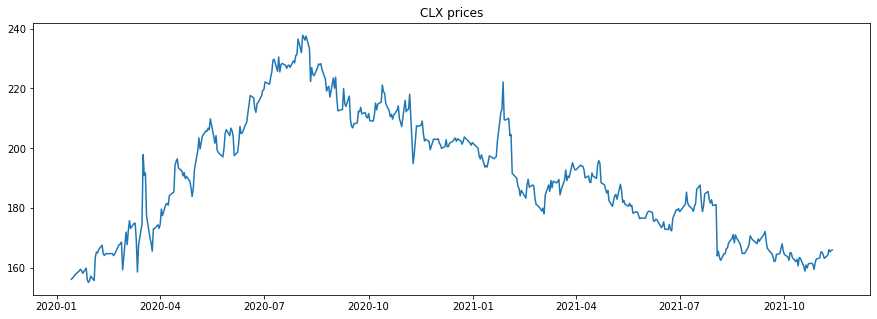

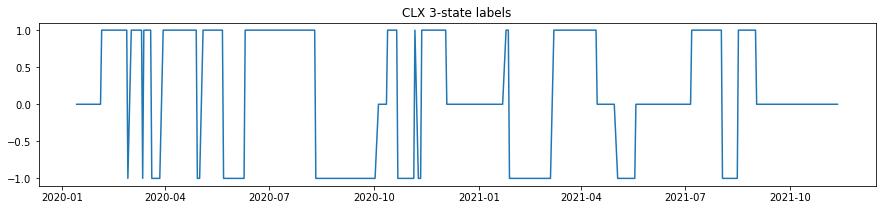

In [4]:
for stock in symbols:
    labels = labeling_algorithm.get_series_labels(close_prices[N:][stock], 0.05, 11)

    plt.figure(figsize=(15, 5), facecolor='w')
    plt.plot(close_prices[N:].index, close_prices[N:][stock])
    plt.title('{} prices'.format(stock))
    plt.show()
    plt.figure(figsize=(15, 3), facecolor='w')
    plt.plot(close_prices[N:].index, labels)
    plt.title('{} 3-state labels'.format(stock))
    plt.show()

## 2-state labeling

Samo trenutno tu za usporedbu s 3-state labeling lagoritmom

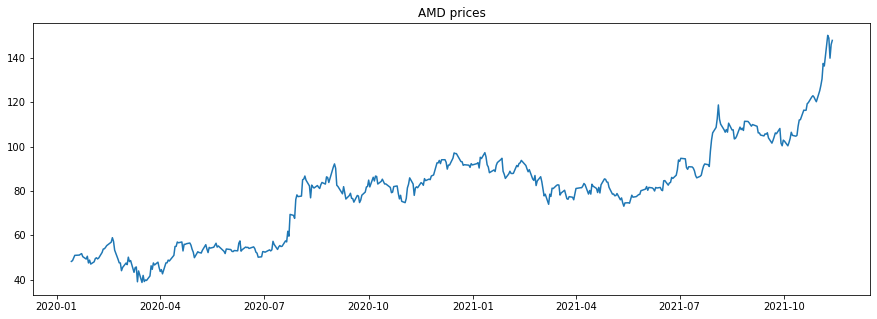

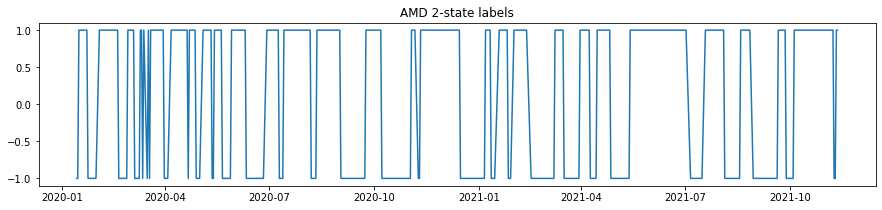

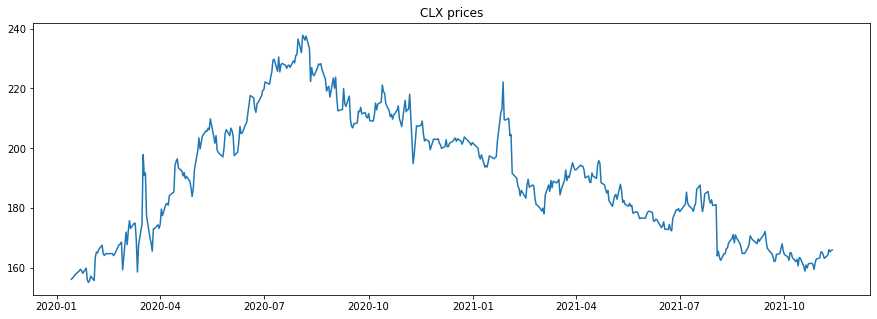

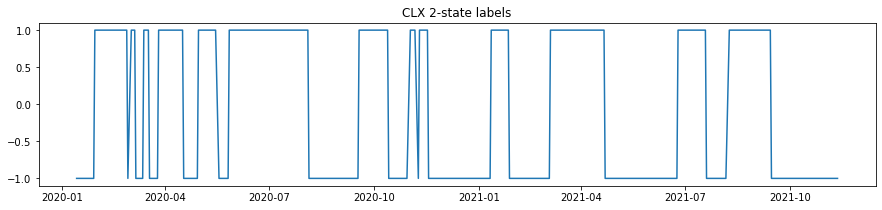

In [5]:
for stock in symbols:
    labels = la2.get_series_labels(close_prices[N:][stock], 0.05)

    plt.figure(figsize=(15, 5), facecolor='w')
    plt.plot(close_prices[N:].index, close_prices[N:][stock])
    plt.title('{} prices'.format(stock))
    plt.show()
    plt.figure(figsize=(15, 3), facecolor='w')
    plt.plot(close_prices[N:].index, labels)
    plt.title('{} 2-state labels'.format(stock))
    plt.show()

## Features

In [6]:
features = get_available_features()
#create 2-lavel column dataframe, first level is stock symbol, second level is feature name
features_df = pd.DataFrame(columns = pd.MultiIndex.from_product([symbols, features]))

for stock in symbols:
    features_df[stock] = compute_features(stock, close_prices[stock], market_series, N)

features_df = features_df.set_index(close_prices[N:].index)

print(features_df.head(2))

              AMD                                                              \
              Min        Max    Mean       Std  Skewness  Kurtosis Chi-Square   
Date                                                                            
2020-01-14  38.73  49.099998  43.865  3.755966 -0.016605 -1.585665   2.915860   
2020-01-15  38.73  49.099998  44.167  3.727913 -0.144715 -1.557263   2.918515   

                                           CLX                          \
                Beta   Mean_Volume         Min         Max        Mean   
Date                                                                     
2020-01-14 -0.016404  4.893953e+07  147.949997  156.199997  151.923999   
2020-01-15 -0.035836  4.963797e+07  147.949997  156.250000  152.191332   

                                                                              
                 Std  Skewness  Kurtosis Chi-Square      Beta    Mean_Volume  
Date                                                             

## 10-fold corss validation

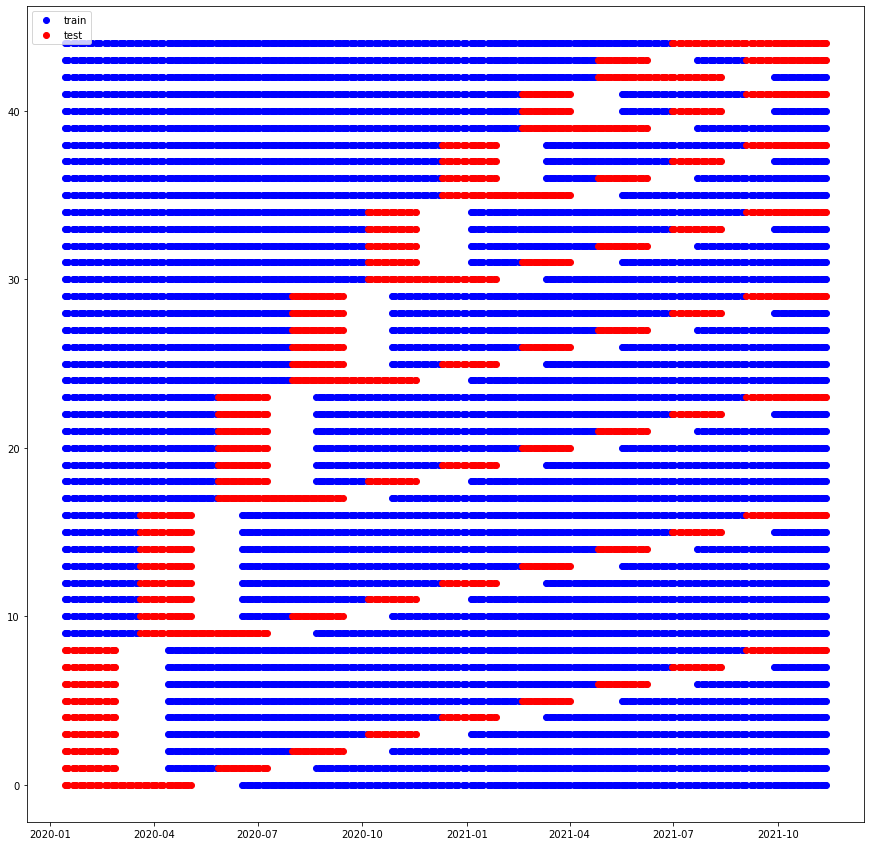

In [7]:
myCVindices = simple_ten_fold_cv_selection(len(close_prices[N:]), N)

plt.figure(figsize=(15, 15), facecolor='w')
for i in range(0, len(myCVindices)):
    trainIndices = myCVindices[i][0]
    testIndices = myCVindices[i][1]

    plt.plot(close_prices[N:].index[trainIndices], [i]*len(trainIndices), 'bo')
    plt.plot(close_prices[N:].index[testIndices], [i]*len(testIndices), 'ro')

plt.legend(['train', 'test'])
plt.show()


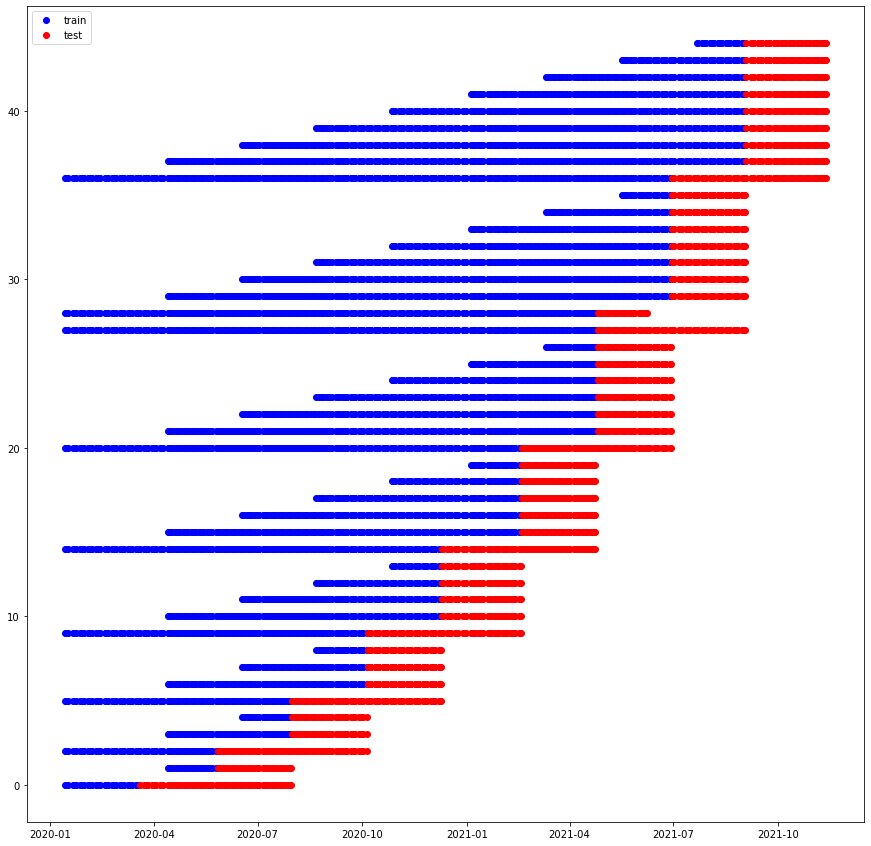

In [8]:
#sort myCVindices without data leakage

myCVindices = custom_ten_fold_cv_selection(len(close_prices[N:]), N)

plt.figure(figsize=(15, 15), facecolor='w')
for i in range(0, len(myCVindices)):
    trainIndices = myCVindices[i][0]
    testIndices = myCVindices[i][1]

    plt.plot(close_prices[N:].index[trainIndices], [i]*len(trainIndices), 'bo')
    plt.plot(close_prices[N:].index[testIndices], [i]*len(testIndices), 'ro')

plt.legend(['train', 'test'])
plt.show()


## Sample weights
The greater the future profit/loss, the greater the sample weight.

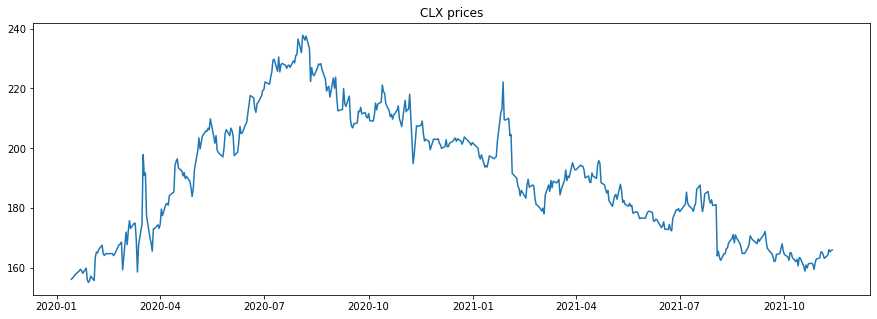

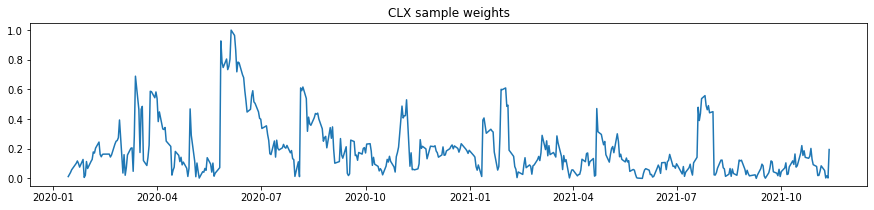

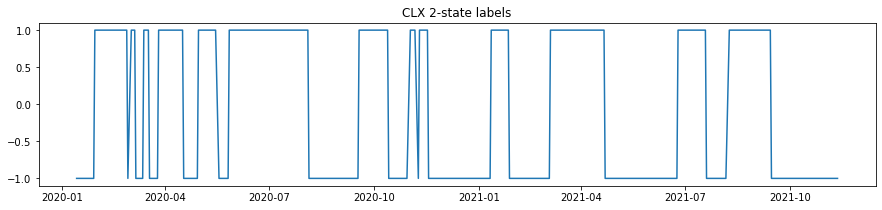

In [9]:
labels = la2.get_series_labels(close_prices[N:]['CLX'], 0.05)
sw_arr = sample_weights.get(close_prices[N:]['CLX'], labels)

plt.figure(figsize=(15, 5), facecolor='w')
plt.plot(close_prices[N:]['CLX'].index, close_prices[N:][stock])
plt.title('{} prices'.format(stock))
plt.show()

plt.figure(figsize=(15, 3), facecolor='w')
plt.plot(close_prices[N:]['CLX'].index, sw_arr)
plt.title('{} sample weights'.format(stock))
plt.show()

plt.figure(figsize=(15, 3), facecolor='w')
plt.plot(close_prices[N:]['CLX'].index, labels)
plt.title('{} 2-state labels'.format(stock))
plt.show()

XGBoost for CLX with 2-state labeling algorithm

In [11]:
stock = 'CLX'
N = 30

start_date_train = '2005-01-01'
end_date_train = '2015-12-31'
prices_train = yf.download(stock, start_date_train, end_date_train, progress=False)['Close']
market_prices_train = yf.download('SPY', start_date_train, end_date_train, progress=False)['Close']

start_date_test = '2016-01-01'
end_date_test = '2017-12-31'
prices_test = yf.download(stock, start_date_train, end_date_train, progress=False)['Close']
market_prices_test = yf.download('SPY', start_date_train, end_date_train, progress=False)['Close']

#FEATURES, 'X' of model
features_train = compute_features(stock, prices_train, market_prices_train, N)
features_test = compute_features(stock, prices_test, market_prices_test, N)

#LABELS, 'Y' of model
labels_train = la2.get_series_labels(prices_train[N:], 0.05)
labels_train[labels_train == -1] = 0
labels_test = la2.get_series_labels(prices_test[N:], 0.05)
labels_test[labels_test == -1] = 0

#SAMPLE WEIGHTS
sw_train = sample_weights.get(prices_train[N:], labels_train)
sw_test = sample_weights.get(prices_test[N:], labels_test)

#CROSS VALIDATION INDICES
cv_inidces_list = custom_ten_fold_cv_selection(len(prices_train[N:]), N)
cv_inidces_list = remove_monoton_instances(cv_inidces_list, labels_train)

#SCALE POS WEIGHT
pos_weight = np.sum(labels_train == 0) / np.sum(labels_train == 1)

In [5]:
print('Simple model:')
xgb_utils.grid_search_cv_acc(features_train, labels_train, cv_inidces_list, saving_file='saved_models/{}_simple.json'.format(stock))
print('Class balancing model:')
xgb_utils.grid_search_cv_acc(features_train, labels_train, cv_inidces_list, scale_pos_weight=pos_weight, saving_file='saved_models/{}_class_balancing.json'.format(stock))
print('Sample weight model:')
xgb_utils.grid_search_cv_acc(features_train, labels_train, cv_inidces_list, sw_train=sw_train, saving_file='saved_models/{}_sample_weight.json'.format(stock))

All models are optimized with GridSearchCV.
<br><br>
'simple' - model with basic parameters without class/sample weighting
<br>
'simple_sw' - 'simple' model tested on sample weighted test data
<br>
'class_balan' - model with class balancing
<br>
'class_balan_sw' - 'class_balan' model tested on sample weighted test data
<br>
'sample_weight' - model with sample weighting
<br>
'sample_weight_sw' - 'sample_weight' model tested on sample weighted test data

In [14]:
m_simple = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_simple.json'.format(stock))
m_simple_sw = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_simple.json'.format(stock), sw_test=sw_test)
m_class_balan = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_class_balancing.json'.format(stock))
m_class_balan_sw = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_class_balancing.json'.format(stock), sw_test=sw_test)
m_sample_weight = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_sample_weight.json'.format(stock), sw_train=sw_train)
m_sample_weight_sw = xgb_utils.test_model(features_train, features_test, labels_train, labels_test, 'saved_models/{}_sample_weight.json'.format(stock), sw_train=sw_train, sw_test=sw_test)

m_df = pd.DataFrame(columns = ['Sample Weight Test', 'acc', 'f1', 'mse', 'auc'])
m_df.loc['simple'] = [False] + list(m_simple.values())
m_df.loc['simple_sw'] = [True] + list(m_simple_sw.values())
m_df.loc['class_balan'] = [False] + list(m_class_balan.values())
m_df.loc['class_balan_sw'] = [True] + list(m_class_balan_sw.values())
m_df.loc['sample_weight'] = [False] + list(m_sample_weight.values())
m_df.loc['sample_weight_sw'] = [True] + list(m_sample_weight_sw.values())

print("Models testing for 'CLX' stock.")
print(m_df)

Models testing for 'CLX' stock.
                 Sample Weight Test       acc        f1       mse       auc
simple                        False  0.764147  0.830801  0.235853  0.709672
simple_sw                      True  0.842476  0.905910  0.157524  0.690381
class_balan                   False  0.995984  0.996805  0.004016  0.996815
class_balan_sw                 True  0.999125  0.999461  0.000875  0.999461
sample_weight                 False  0.676889  0.787719  0.323111  0.580134
sample_weight_sw               True  0.851125  0.914947  0.148875  0.626989
